# Homework 6

##### Data: HW6_data.csv

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 20th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Place the name of everyone who's submitting this assignment here**

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats as sc
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

## Question 1: Can I sample from F-R-I-E-N-D-S without rejection?  It's Important!

**Coding required**


*Haven't we made it obvious?* In HW 5 we were introduced to $X$ a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

*Haven't we made it clear?*  We were also introduced to $h$ the following function of $X$:

$$h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}$$


*Want us to spell it out for you?* Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:

**1.1.** Rejection sampling with a normal proposal distribution and appropriately chosen parameters (aka rejection on steroids)

In [2]:
# probability distribution we're trying to sample from
def p(x):
    if x >= 1 and x <= 3:
        return 1/12*(x-1)
    elif x > 3 and x <= 5:
        return -1/12*(x-5)
    elif x > 5 and x <= 7:
        return 1/6*(x-5)
    elif x > 7 and x <= 9:
        return -1/6*(x-9)
    else:
        0

In [3]:
# define gaussian mixture model (makes more sense than normal for bimodal distribution)
class guassian_mixture(object):
    def __init__(self, m1,s1,m2,s2,p):
            self.m1 = m1
            self.s1 = s1
            self.m2 = m2
            self.s2 = s2
            self.p = p
                
    def sample(self, size = 1):
        samples = []
        for _ in range(size):
            g1_or_g2 = sc.binom.rvs(1,self.p)
            if g1_or_g2 == 0:
                samples.append(sc.norm.rvs(loc = self.m1, scale = self.s1))
            else:
                samples.append(sc.norm.rvs(loc = self.m2, scale = self.s2))
        if size == 1:
            return samples[0]
        else:
            return samples
            
        
    def pdf(self, x):
        return ((1-self.p)*sc.norm.pdf(x, loc = self.m1, scale = self.s1) 
                + self.p*sc.norm.pdf(x, loc = self.m2, scale = self.s2))
    
    def cdf(self, x):
        return ((1-self.p)*sc.norm.cdf(x, loc = self.m1, scale = self.s1) 
                + self.p*sc.norm.cdf(x, loc = self.m2, scale = self.s2))

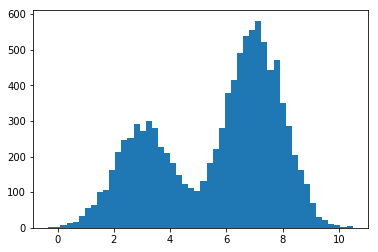

In [4]:
gauss_mix = guassian_mixture(3,1,7,1,.66)
gauss_mix_samples = gauss_mix.sample(10000)
plt.hist(gauss_mix_samples,bins = 50)
plt.show()

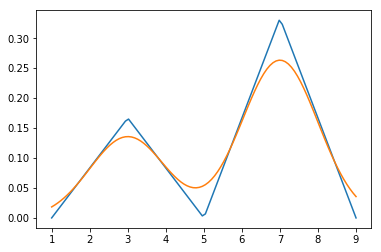

In [5]:
xx = np.linspace(1,9,100)
p_x = [p(x) for x in xx]
plt.plot(xx, p_x)
plt.plot(xx, gauss_mix.pdf(xx))

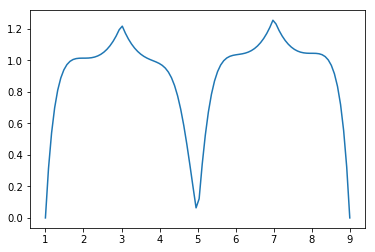

In [6]:
fbyg = p_x/gauss_mix.pdf(xx)
plt.plot(xx, fbyg)

In [7]:
M = fbyg[np.argmax(fbyg)]
M

1.253207214315986

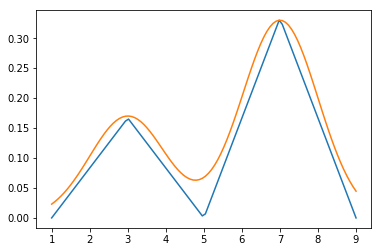

In [8]:
plt.plot(xx, p_x)
plt.plot(xx, M*gauss_mix.pdf(xx))

In [9]:
# domain limits
xmin = 1 # the lower limit of our domain
xmax = 9 # the upper limit of our domain


N = 10000 # the total of samples we wish to generate
accepted = 0 # the number of accepted samples
samples = np.zeros(N)
count = 0 # the total count of proposals
outside = 0

# generation loop
while (accepted < N):
    
    while 1:
        xproposal = gauss_mix.sample()
        if xproposal > xmin and xproposal < xmax:
            break
        outside+=1
    # pick a uniform number on [0, 1)
    y = np.random.uniform(0,1)
    
    # Do the accept/reject comparison
    if y < p(xproposal)/(M*gauss_mix.pdf(xproposal)):
        samples[accepted] = xproposal
        accepted += 1
    
    count +=1
    
print("Count", count, "Accepted", accepted, "Outside", outside)


Count 12266 Accepted 10000 Outside 287


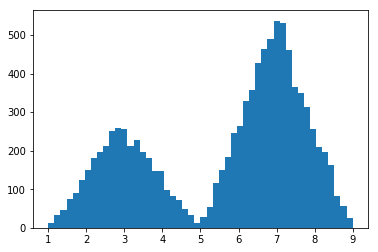

In [10]:
plt.hist(samples,bins = 50)
plt.show()

In [11]:
h = lambda x: 1/(3*np.sqrt(2)*np.pi)*np.exp(-1/18*(x - 5)**2)
np.mean(h(samples))

0.05895532096087287

**1.2.** Importance sampling with a uniform proposal distribution

In [12]:
samples = sc.uniform.rvs(1,8,100000)
fbyg = lambda x: p(x)/sc.uniform.pdf(x,1,8)
np.mean([h(s)*fbyg(s) for s in samples])

0.058722300987900086

**1.3.** Importance sampling with a normal proposal distribution and appropriately chosen parameters

In [13]:
gauss_mix = guassian_mixture(3,1,7,1,.66)
samples = gauss_mix.sample(10000)
samples_in_range = [s for s in samples if 1 < s and s < 9]
normer = 1/(gauss_mix.cdf(9) - gauss_mix.cdf(1))
fbyg = lambda x: p(x)/(normer*gauss_mix.pdf(x))
np.mean([h(s)*fbyg(s) for s in samples_in_range])

0.05861418075082972

--

**1.4.** So far (in HWs 5 and 6) we've computed estimates of $\mathbb{E}[h(X)]$ for the following list of methods:

* Inverse Transform Sampling
* Rejection Sampling with a uniform proposal distribution (rejection sampling in a rectangular box with uniform probability of sampling any x)
* Rejection sampling with a normal proposal distribution and appropriately chosen parameters (aka rejection on steroids)
* Importance sampling with a uniform proposal distribution
* Importance sampling with a normal proposal distribution and appropriately chosen parameters.

Compute the variance of each estimate of $\mathbb{E}[h(X)]$ you calculated in this list. 

In [33]:
# CDF of p
def cdf(x):
    if x >= 1 and x <= 3:
        return 1/24*(x-1)**2
    elif x > 3 and x <= 5:
        return -1/24*(x-5)**2 + 1/3
    elif x > 5 and x <= 7:
        return 1/12*(x-5)**2 +1/3
    elif x > 7 and x <= 9:
        return -1/12*(x-9)**2 +1
    else:
        0

In [34]:
# invert the CDF
def invCDF(r):
    if r >= 0 and r <= 1/6:
        return np.sqrt(24*r)+1
    elif r > 1/6 and r <= 1/3:
        return -np.sqrt(-24*(r-1/3))+5
    elif r > 1/3 and r <= 2/3:
        return np.sqrt(12*(r-1/3))+5
    elif r > 2/3 and r <= 1:
        return -np.sqrt(-12*(r-1))+9
    else:
        raise ValueError("r is outside the valid range")

## Inverse Transform Sampling

In [35]:
def calc_inverse_approx(N):
    # domain limits
    xmin = 1 # the lower limit of our domain
    xmax = 9 # the upper limit of our domain

    # range limits
    rmin = cdf(xmin)
    rmax = cdf(xmax)

    # generate uniform samples in our range then invert the CDF
    # to get samples of our target distribution
    R = np.random.uniform(rmin, rmax, N)
    X = np.array([invCDF(r) for r in R])

    # calculate expected value
    h = lambda x: 1/(3*np.sqrt(2)*np.pi)*np.exp(-1/18*(x - 5)**2)
    return np.mean(h(X))

In [36]:
inverse_approx = [calc_inverse_approx(100) for _ in range(100)]
np.var(inverse_approx)

1.343451326704829e-06

## Rejection Sampling with a uniform proposal distribution

In [37]:
def calc_rejection_unif_approx(N):
    exp_h_integrand = lambda x: h(x)*p(x)
    X = np.random.uniform(1, 9, N)
    y_max = 0.02
    Y_sample = np.random.uniform(0,y_max,N)
    exp_h_sample = np.array([exp_h_integrand(x) for x in X])
    accepted = exp_h_sample > Y_sample
    accepted_prop = sum(accepted)/len(accepted)
    return accepted_prop*(9-1)*y_max

In [38]:
rejection_unif_approx = [calc_rejection_unif_approx(100) for _ in range(100)]
np.var(rejection_unif_approx)

6.0820223999999996e-05

## Rejection Sampling with a normal proposal distribution

In [39]:
def calc_rejection_norm_approx(N, M):
    # domain limits
    xmin = 1 # the lower limit of our domain
    xmax = 9 # the upper limit of our domain


    accepted = 0 # the number of accepted samples
    samples = np.zeros(N)
    count = 0 # the total count of proposals
    outside = 0

    # generation loop
    while (accepted < N):

        while 1:
            xproposal = gauss_mix.sample()
            if xproposal > xmin and xproposal < xmax:
                break
            outside+=1
        # pick a uniform number on [0, 1)
        y = np.random.uniform(0,1)

        # Do the accept/reject comparison
        if y < p(xproposal)/(M*gauss_mix.pdf(xproposal)):
            samples[accepted] = xproposal
            accepted += 1

        count +=1
    return np.mean(h(samples))



In [40]:
rejection_norm_approx = [calc_rejection_norm_approx(100, M) for _ in range(100)]
np.var(rejection_norm_approx)

1.2130639830341786e-06

## Importance Sampling Uniform

In [41]:
def calc_importance_unif(N):
    samples = sc.uniform.rvs(1,8,N)
    fbyg = lambda x: p(x)/sc.uniform.pdf(x,1,8)
    return np.mean([h(s)*fbyg(s) for s in samples])

In [42]:
importance_unif = [calc_importance_unif(100) for _ in range(100)]
np.var(importance_unif)

1.7139254698922007e-05

## Importance Sampling Normal

In [43]:
def calc_importance_norm(N):
    gauss_mix = guassian_mixture(3,1,7,1,.66)
    samples = gauss_mix.sample(N)
    samples_in_range = [s for s in samples if 1 < s and s < 9]
    normer = 1/(gauss_mix.cdf(9) - gauss_mix.cdf(1))
    fbyg = lambda x: p(x)/(normer*gauss_mix.pdf(x))
    return np.mean([h(s)*fbyg(s) for s in samples_in_range])

In [44]:
importance_norm = [calc_importance_norm(100) for _ in range(100)]
np.var(importance_norm)

2.1839688955275674e-06

Which sampling methods and associated proposal distributions would you expect based on discussions from lecture to have resulted in lower variances? How well do your results align with these expectations?

**Gratuitous Titular Reference**:  Annemarie and Marshmello's [F-R-I-E-N-D-S](https://www.youtube.com/watch?v=CY8E6N5Nzec) samples from French Hip Hop artist Rapsa's [42 Mesures à ta Sa(i)nté](https://www.youtube.com/watch?v=JivaoPSAgLI) a homage to his hometown of Saint-Étienne.

<div class="answer-separator">
------------------------
</div>

## Question 2: Mr. Poe Writes of Gradient Descent Into the Maelström`

Suppose you are building a pricing model for laying down telecom cables over a geographical region. You construct a pricing model that takes as input a pair of coordinates, $(x_1, x_2)$ and based upon two parameters $\lambda_1, \lambda_2$ predicts the loss in revenue corresponding to laying the cables at the inputed location.  Your pricing model is described by the following equation:

$$
\mathcal{L}(x_1, x_2\ \vert\ \lambda_1, \lambda_2) = 0.000045\lambda_2^2 x_2 - 0.000098\lambda_1^2 x_1 + 0.003926\lambda_1 x_1\exp\left\{\left(x_2^2 - x_1^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$

We've provided you some data contained in the file `HW6_data.csv`. This data represents a set of coordinates configured on the curve $x_2^2 - x_1^2 = -0.1$. Your general goal for this problem is to find the parameters $\lambda_1, \lambda_2$ that  minimize the net loss over the entire dataset.

**2.1.** Construct an appropriate visualization of the loss function for the given data.  Use that visualization to verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized.  Your visualization should make note of this optima.

In [56]:
data = pd.read_csv('./HW6_data.csv')
data.tail()

,X_1,X_2
15995,-59.451012,-59.450171
15996,-91.805088,91.804543
15997,-97.916107,-97.915596
15998,-49.388900,49.387887
15999,-56.236041,56.235152


In [339]:
def loss(x1, x2, lambda1, lambda2):
    return (0.000045*lambda2**2*x2 
            - 0.000098*lambda1**2*x1 
            + 0.003926*lambda1*x1*np.exp((x2**2 - x1**2)*(lambda1**2 + lambda2**2))
           )

def total_log_loss(data, lambda1, lambda2):
    losses = np.array([loss(row.X_1, row.X_2, lambda1, lambda2) for _, row in data.iterrows()])
    return np.sum(losses, axis = 0)
    
def stochastic_log_loss(data, lambda1, lambda2):
    return loss(data.X_1, data.X_2, lambda1, lambda2)/16000

In [170]:
lambda1 = np.linspace(-10,10,100)
lambda2 = np.linspace(-10,10,100)

lambda1_mesh, lambda2_mesh =  np.meshgrid(lambda1, lambda2)
Z = total_log_loss(data, lambda1_mesh, lambda2_mesh)
Z.shape

(100, 100)

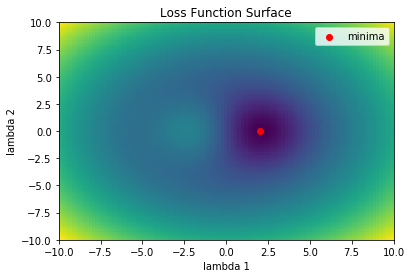

In [171]:
plt.pcolor(lambda1_mesh, lambda2_mesh, Z)
plt.scatter(2.05384, 0, c='r', label = 'minima')
plt.xlabel('lambda 1')
plt.ylabel('lambda 2')
plt.title('Loss Function Surface')
plt.legend()

**2.2.** Choose an appropriate learning rate  from [10, 1, 0.1, 0.01, 0.001, 0.0001] and use that learning rate to implement gradient descent.  Use your implementation to minimize $L$ for the given data.  Your implementation should be stored in a function named `gradient_descent`.  `gradient_descent` should take the following parameters (n represents the number of data points):

- `lambda_init` -- a numpy array with shape (2 , 1) containing the initial value for $\lambda_1$ and $\lambda_2$
- `X_data` -- an numpy array with shape (n, 2) containing the data coordinates used in your loss function
- `step_size` -- a float containing the step-size/learning rate used in your algorithm
- `scale` -- a float containing the factor by which you'll scale your step_size (or alternatively your loss) in the algorithm
- `max_iterations` -- an integer containing a cap on the number of iterations for which you'll let your algorithm run
- `precision` -- a float containing the difference in loss between consecutive iterations below which you'll stop the algorithm
- `loss` -- a function (or lambda function) that takes in the following parameters and returns a float with the results of calculating the loss function for our data at $\lambda_1$ and $\lambda_2$
    - `lambdas` -- a numpy array with shape (2, 1) containing $\lambda_1$ and $\lambda_2$
    - `X_data` -- the same as the parameter `X_data` for `gradient_descent`
    
The return value for `gradient_descent` should be a dictionary with the following keys (n_itertions represents the total number of iterations):
- 'lambdas' -- the associated value is a numpy array with shape (2,1) containing the optimal $\lambda$'s found by the algorithm
- 'history' -- the associated value is a numpy array with shape (n_iterations,) containing a history of the calculated value of the loss function at each iteration

In [380]:
def get_grad(data, lambda_params, loss):
    # calculates gradient with via symmetric difference quotient
    grad = np.zeros(2)
    epsilon = 1e-5
    grad[0] = (loss(data, lambda_params[0]+epsilon, lambda_params[1])
               -loss(data, lambda_params[0]-epsilon, lambda_params[1]))/(2*epsilon)
    grad[1] = (loss(data, lambda_params[0], lambda_params[1]+epsilon)
               -loss(data, lambda_params[0], lambda_params[1]-epsilon))/(2*epsilon)
    return grad

In [381]:
def gradient_descent(lambda_init,
                     X_data,
                     step_size,
                     scale,
                     max_iterations,
                     precision,
                     loss):
    lambda_params = lambda_init
    iterations = 0
    loss_val = loss(X_data, lambda_params[0], lambda_params[1])
    history = [loss_val]
    loss_decrease = np.inf
    while loss_decrease > precision and iterations < max_iterations:
        step_size = scale*step_size
        grad = get_grad(X_data, lambda_params, loss)
        lambda_params = lambda_params - step_size * grad
        loss_val = loss(X_data, lambda_params[0], lambda_params[1])
        history.append(loss_val)
        loss_decrease = history[-2] - history[-1]
        iterations += 1
        print('iter',iterations)
        print('lambda',lambda_params)
        print('loss',loss_val)
        print('loss_decrease',loss_decrease)
    return {'lambdas': lambda_params, 'history': np.array(history)}

In [382]:
result = gradient_descent([5,5], data, 1, .8, 100, 1e-5, total_log_loss)

iter 1
lambda [3.22988113 3.18646746]
loss 0.8132496363423627
loss_decrease 8.903251877006682
iter 2
lambda [1.69425499 1.02659436]
loss -8.371121279650197
loss_decrease 9.18437091599256
iter 3
lambda [ 2.52607459 -0.14576738]
loss -9.37526917343962
loss_decrease 1.0041478937894226
iter 4
lambda [1.63566287 0.00530409]
loss -9.479756788507302
loss_decrease 0.10448761506768278
iter 5
lambda [2.35429909e+00 1.12880214e-03]
loss -9.713718551314287
loss_decrease 0.23396176280698455
iter 6
lambda [1.97702067e+00 3.70207867e-04]
loss -9.919106278053505
loss_decrease 0.20538772673921812
iter 7
lambda [2.05916421e+00 1.73054776e-04]
loss -9.934032730066747
loss_decrease 0.014926452013241942
iter 8
lambda [2.05466696e+00 9.88550990e-05]
loss -9.934102324745709
loss_decrease 6.959467896194838e-05
iter 9
lambda [2.05411293e+00 6.49576991e-05]
loss -9.93410384433264
loss_decrease 1.5195869309536647e-06


**2.3** For your implementation in 2.2, create a plot of loss vs iteration.  Does your descent algorithm comverge to the right values of $\lambda$?  At what point does your implementation converge?

Text(0.5,1,'Convergence of Gradient Descent')

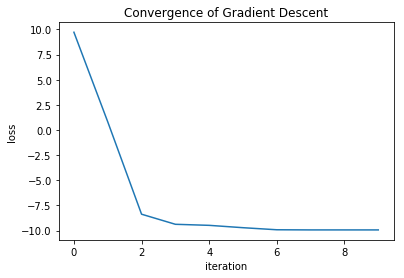

In [175]:
plt.plot(np.arange(len(result['history'])),result['history'])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Convergence of Gradient Descent')

In [176]:
print(result['lambdas'])

[2.05411293e+00 6.49576991e-05]


The algorithm converges to approximately the correct values of lambda. It converges after about 4 iterations.

**2.4.** Choose an appropriate learning rate  from [10, 1, 0.1, 0.01, 0.001, 0.0001] and use that learning rate to implement stochastic gradient descent.  Use your implementation to minimize $L$ for the given data.  Your implementation should a stored in a function named `stochastic_gradient_descent`.  `stochastic_gradient_descent` should take the following parameters (n represents the number of data points):

- `lambda_init` -- a numpy array with shape (2 , 1) containing the initial value for $\lambda_1$ and $\lambda_2$
- `X_data` -- an numpy array with shape (n, 2) containing the data coordinates for your loss function
- `step_size` -- a float containing the step-size/learning rate used in your algorithm
- `scale` -- a float containing the factor by which you'll scale your step_size (or alternatively your loss) in the algorithm
- `max_iterations` -- an integer containing a cap on the number of iterations for which you'll let your algorithm run
- `precision` -- a float containing the difference in loss between consecutive iterations below which you'll stop the algorithm
- `loss` -- a function (or lambda function) that takes in the following parameters and returns a float with the results of calculating the loss function for our data at $\lambda_1$ and $\lambda_2$
    - `lambdas` -- a numpy array with shape (2, 1) containing $\lambda_1$ and $\lambda_2$
    - `X_data` -- the same as the parameter `X_data` for `stochastic_gradient_descent`
    
The return value for `stochastic_gradient_descent` should be a dictionary with the following keys (n_itertions represents the total number of iterations):
- 'lambdas' -- the associated value is a numpy array with shape (2,1) containing the optimal $\lambda$'s found by the algorithm
- 'history' -- the associated value is a numpy array with shape (n_iterations,) containing a history of the calculated value of the loss function at each iteration

In [386]:
def stochastic_gradient_descent(lambda_init,
                     X_data,
                     step_size,
                     scale,
                     max_epochs,
                     precision,
                     loss,
                     loss_total):
    lambdas = [lambda_init]
    X_data = pd.DataFrame(np.random.permutation(X_data),columns = ['X_1','X_2'])
    epochs = 0
    loss_val = loss_total(X_data, lambdas[-1][0], lambdas[-1][1])
    history = [loss_val]
    loss_decrease = np.inf
    row = 0
    while (loss_decrease > precision or loss_decrease < 0) and epochs < max_iterations:
        if row >= len(X_data)-1:
            row = 0
            epochs = epochs + 1
            X_data = pd.DataFrame(np.random.permutation(X_data),columns = ['X_1','X_2'])
            print(lambdas[-1]-lambdas[-16000])
            loss_val = loss_total(X_data, lambdas[-1][0], lambdas[-1][1])
            history.append(loss_val)
        else:
            row = row + 1
        step_size = scale*step_size
        grad = get_grad(X_data.loc[row], lambdas[-1], loss)
        lambdas.append(lambdas[-1] - step_size * grad)
    return {'lambdas': np.array(lambdas), 'history': np.array(history)}

In [387]:
result = stochastic_gradient_descent([5,5], data, 2000, 0.9999**(1/16000), 20, 1e-5/16000, stochastic_log_loss, total_log_loss)

[-0.3213829  -0.22987317]
[-0.325292   -0.25256463]
[-0.30910651 -0.18926603]
[-0.30896505 -0.14673216]
[-0.32758181 -0.22628656]
[-0.3143952  -0.18735748]
[-0.53345535 -0.19608575]
[-0.35180516 -0.29974762]
[-0.2211812  -0.29350915]
[-0.15458507 -0.24790891]
[-0.03468602 -0.36609769]
[ 0.0871103  -0.63359107]
[ 0.08837831 -0.73594697]
[ 0.02999548 -0.45518922]
[ 0.01110222 -0.27701581]
[ 0.00257524 -0.13267854]
[ 0.00063929 -0.06121099]
[ 0.0001393  -0.02874876]
[ 2.33604098e-05 -1.31379424e-02]
[ 5.57294840e-06 -6.01768589e-03]


**2.5** For your implementation in 2.4, create a plot of loss vs iteration.  Does your descent algorithm comverge to the right values of $\lambda$?  At what point does your implementation converge?

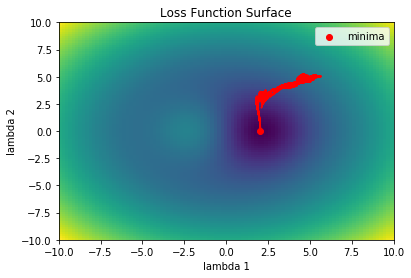

In [388]:
plt.pcolor(lambda1_mesh, lambda2_mesh, Z)
plt.scatter(2.05384, 0, c='r', label = 'minima')
plt.plot(result['lambdas'][:,0],result['lambdas'][:,1], c='r')
plt.xlabel('lambda 1')
plt.ylabel('lambda 2')
plt.title('Loss Function Surface')
plt.legend()

Text(0.5,1,'Convergence of Gradient Descent')

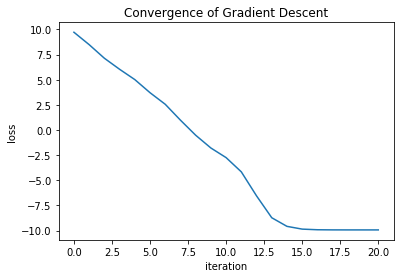

In [389]:
plt.plot(np.arange(len(result['history'])),result['history'])
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Convergence of Stochastic Gradient Descent')

The algorithm converges after 12 iterations.

**2.6** Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.

An iteration of stochastic gradient descent is much faster than gradient descent. This is because the evaluating the gradient over the inter dataset is computationally intensive, whereas calculating the gradient for a single `X_1, Y_1` pair is easy.

**2.7** Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3`.  You may wish to set a cap for maximum number of iterations.  Which method converges to the optimal point in fewer iterations?  Briefly explain why this result should be expected.

Gradient descent converges to the optimal point in fewer iterations for two reasons:
1. The step size for gradient descent is 16000 times larger than the step size in gradient descent. This means that 

**2.8** Compare the performance of stochastic gradient descent on our loss function and dataset for the following learning rates: [10, 1, 0.1, 0.01, 0.001, 0.0001]. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of the algorithm.

**2.9** Using your implementation of gradient descent and stochastic gradient descent, document the behavior of your two algorithms for the following starting points, and for a number of stepsizes of your choice:

- $(\lambda_1, \lambda_2) = (-2.47865, 0)$
- $(\lambda_1, \lambda_2) = (-3, 0)$
- $(\lambda_1, \lambda_2) = (-5, 0)$
- $(\lambda_1, \lambda_2) = (-10, 0)$

Construct a mathematical analysis of the loss function $\mathcal{L}$ to explain results of your descent algorithms at different starting points.

**Gratuitous Titular Reference**:  The renowned American auteur Edgar Allen Poe penned ["A Descent into the Maelström"](https://en.wikipedia.org/wiki/A_Descent_into_the_Maelstr%C3%B6m), a macabre tale of a seemingly elderly man's surviving a previous horrendous encounter with a massive hurricane, a shipwreck and a sea vortex, in 1841.

<div class="answer-separator">
------------------------
</div>